In [50]:
# Initial Imports
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn import preprocessing

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Extraction And Cleaning

In [5]:
# Read in lyrics data
lyrics = pd.read_csv("data/songdata.csv")

In [6]:
# Required columns
cols=['song', 'artist', 'trackid', 'danceability', 'energy', 'key', 'mode', 
      'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
      'valence', 'tempo', 'duration_ms', 'time_signature',
     'duration', 'analysis_sample_rate', 'analysis_channels', 
      'end_of_fade_in', 'start_of_fade_out', 'loudness', 'tempo', 'tempo_confidence', 
      'time_signature', 'time_signature_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence']

In [7]:
cols = list(np.unique(cols))

In [8]:
# Creating dataframe for audio features
features=pd.DataFrame(columns=cols)

#### Getting Data Ready before Clustering

In [9]:
artists = ['Eminem', 'Passenger', 'Bruno Mars', 'Coldplay', 'Ozzy Osbourne', 'Slayer','Metallica','Beatles','Dire Straits' ,'Radiohead', 'Taylor Swift', 'Aerosmith','Ed Sheeran', 'Drake', 'Pink Floyd', 'Queen', 'Billy Joel', 'Iron Maiden', 'Black Sabbath','Green Day' ]

In [10]:
songs = ['Let It Be', 'Let Her Go','Hey Jude', '', 'Marry You','Yellow', 'The Lazy Song','Norwegian Wood', 'Wonderful Tonight',  'Imagine', 'I Knew You Were Trouble', 'Love Story', 'A Team', 'Sing', 'Bohemian Rhapsody', 'Electric Funeral', 'Valhalla', 'American Idiot', 'Angel Of Death', 'War Pigs', 'The Trooper']

In [11]:
# Filtering on artist
lyrics = lyrics[lyrics.artist.isin(artists)]
# Select songs based on the list of songs or a list of artists or both
songs_selected = lyrics[lyrics.song.isin(songs)]

In [12]:
songs_selected.shape

(16, 4)

In [13]:
# sample dataframe is used for all analysis here on
sample = songs_selected
sample.reset_index(inplace=True)

##### Extracting Audio Feautures using spotify API 

In [14]:
# Get audio features for the songs in the sample dataframe
# Client Credentials
client_id = "5fc0da4106eb48e1913868f4950828fb"
client_secret = "5a549bc4674e47dfaf3b06da4500a44d"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

for index,row in sample.iterrows():
    song = row['song']
    
    temp = pd.DataFrame(columns = cols)
    temp['song'] = [song]
    temp['artist'] = [row['artist']]
    
    try:
        result = sp.search(song, type='track', limit=1)

    except:
        print('SOme error')
        continue
        
    if len(result['tracks']['items']) == 0:
        continue
    
    trackid=result['tracks']['items'][0]['id']
    temp['trackid'] = [trackid]
    
    try:
        feat=sp.audio_features(trackid)[0]
        analysis=sp.audio_analysis(trackid)['track']
    except error as e:
        print(e)
        continue
    
    combined = {**feat, **analysis}
    
    for col in cols:
        if col in ['song', 'artist', 'trackid']:
            continue
        temp[col]= combined[col]
        
    features = features.append(temp, ignore_index=True)

In [15]:
features = features.T.drop_duplicates().T

##### Getting Word Vectors

In [17]:
# Getting all text for training own word vectors
all_text = ' '.join(lyrics.text)
all_text = all_text.replace('\n', '')
sent_text = nltk.sent_tokenize(all_text)

In [18]:
# Training and saving the word vec model
wv_dimension = 20

tokenizer = RegexpTokenizer(r'\w+').tokenize

sent_tokenized = []
for sent in sent_text:
    sent_tokenized.append(tokenizer(sent))
    
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

path = get_tmpfile("word2vec.model")
model = Word2Vec(sent_tokenized, size=wv_dimension, window=5, min_count=3, workers=4)

model.save("word2vec.model")

In [36]:
# Finding wv representation for the lyrics in the dataframe sample
# Creating a dataframe wv with the word vectors
wv = []
for lyr in sample.text:
    vec = [0] * wv_dimension
    c = 0
    words = tokenizer(lyr)
    for word in words:
        try:
            vec = vec + model[word]
            c = c + 1
        except:
            vec = vec + [0] * wv_dimension
    vec = np.array(vec) / c
    wv.append(vec)

In [37]:
# Namingg the columns in wv to 1-wv_dimension
req_cols = list(range(wv_dimension))
wv_df = pd.DataFrame(wv)[req_cols]
wv_df['song'] = sample['song']

In [38]:
# Making a copy for preservation
features_copy = features.copy()

In [39]:
# Merging features and wv to get dataframe with audio features and the word vectors
df_all = pd.merge(features, wv_df, how='left', on='song')
# Removing empty rows
df_all = df_all[df_all['trackid'] != 'NA']

In [40]:
# Drop rows with NA values
df_all = df_all.dropna()

In [41]:
df_all.reset_index(inplace=True, drop=True)

In [42]:
# Get a list of column in the consolidated dataframe
cols = list(df_all.columns)

In [43]:
# Remove columns not required for clustering
cols.remove('song')
cols.remove('artist')
cols.remove('trackid')

In [45]:
df=df_all

In [59]:
dfcols = list(df.columns)

In [60]:
# Removing unnecessary columns from the list of columns for clustering
dfcols.remove('song')
dfcols.remove('artist')
dfcols.remove('trackid')

#### Sentiment Analysis 

In [61]:
# Getting sentiment for the sample
sentiment_data = pd.DataFrame(columns=['positive', 'negative', 'neutral', 'compound', 'song'])
for index, row in sample.iterrows():
    pos = []
    neg = []
    neu = []
    compound = []
    sentences=nltk.sent_tokenize(row.text)
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
        neu.append(vs['neu'])
        compound.append(vs['compound'])
    tmp = pd.DataFrame([[np.average(pos), np.average(neg), np.average(neu), np.average(compound), row['song']]], columns=['positive', 'negative', 'neutral', 'compound', 'song'])
    sentiment_data = pd.concat([sentiment_data, tmp], ignore_index=True)

In [62]:
# Merge the dataset to add sentiment calues
df_with_sentiment = pd.merge(df_all, sentiment_data, how='left', on='song')

In [63]:
# Scaling the dataframe
x = df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_with_sentiment = pd.DataFrame(x_scaled, columns=dfcols + ['positive', 'negative', 'neutral', 'compound'])
df_with_sentiment['song'] = df_all['song']
df_with_sentiment['artist'] = df_all['artist']

### Clustering Using Hierarchical Clustering

In [64]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])

df_with_sentiment.label=cluster.labels_

In [65]:
list(df_with_sentiment[df_with_sentiment.label==0]['song'])

['Marry You',
 'The Lazy Song',
 'Yellow',
 'Let Her Go',
 'I Knew You Were Trouble',
 'Love Story',
 'Sing',
 'Bohemian Rhapsody']

In [66]:
list(df_with_sentiment[df_with_sentiment.label==1]['song'])

['American Idiot', 'War Pigs', 'Valhalla', 'The Trooper']

In [67]:
list(df_with_sentiment[df_with_sentiment.label==2]['song'])

['Wonderful Tonight', 'A Team']

### Clustering using Kmeans

In [80]:
# Perform Kmeans on the consolidated scaled dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=300).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
df_with_sentiment['label'] = kmeans.labels_

In [81]:
list(df_with_sentiment[df_with_sentiment.label==0]['song'])

['Marry You',
 'The Lazy Song',
 'Yellow',
 'Let Her Go',
 'I Knew You Were Trouble',
 'Love Story',
 'Sing',
 'Bohemian Rhapsody']

In [82]:
list(df_with_sentiment[df_with_sentiment.label==1]['song'])

['American Idiot', 'War Pigs', 'Valhalla', 'The Trooper']

In [83]:
list(df_with_sentiment[df_with_sentiment.label==2]['song'])

['Wonderful Tonight', 'A Team']

#### Cluster Evaluation Metrics 

In [86]:
# Plotting silhouette score for assesing the relative goodness of clusters
from sklearn.metrics import silhouette_score

scores = []
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
    scores.append(silhouette_score(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']], kmeans.labels_))

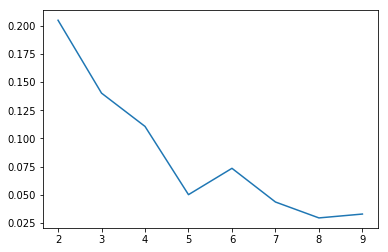

In [87]:
plt.plot(range(2, 10), scores)

In [88]:
# Calculating Dunn Index
req_cols = dfcols + ['positive', 'negative', 'neutral', 'compound'] + ['label']
# Function to calculate eucledian distance
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

def cal_intra_clstr_max_dist(df):
    max_dist = 0
    df = df[req_cols]
    for label in df['label']:
        d = df[df['label'] == label]
        ct = list(d.columns)
        ct.remove('label')
        dv = d[ct].values
        for X in dv:
            distance = np.max(dist(X, dv))
            if distance > max_dist:
                max_dist = distance
    
    return max_dist

def cal_ceteroid_dist(centeroids):
    max_dist = 0
    
    for c in centeroids:
        dis = np.delete(dist(c, centeroids), np.where(dist(c, centeroids) == 0))
        distance = np.min(dis)
        if distance > max_dist:
            max_dist = distance
    
    return max_dist

def cal_dunn_index(df, centeroids):
    return cal_ceteroid_dist(centeroids) / cal_intra_clstr_max_dist(df)

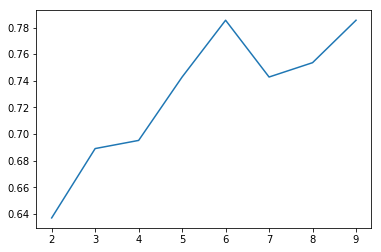

In [89]:
scores = []
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000).fit(df_with_sentiment[dfcols + ['positive', 'negative', 'neutral', 'compound']])
    scores.append(cal_dunn_index(df_with_sentiment, kmeans.cluster_centers_))

plt.plot(range(2, 10), scores)